## Olympic Medalists

Which countries have won the most Olympic medals? Who has won the most too? Exploration of medal winners from 1896 - 2012

Exploration of this data using Pandas

Dataset from the Guardian Newspaper:
- https://www.theguardian.com/sport/datablog/2012/jun/25/olympic-medal-winner-list-data

In [36]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
import matplotlib as mpl

%matplotlib inline

from sklearn import preprocessing as pp 
from scipy.stats import pearsonr 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold 
from sklearn.metrics import log_loss 
from sklearn.metrics import precision_recall_curve, average_precision_score 
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import lightgbm as lgb

import warnings
warnings.filterwarnings('ignore')
color = sns.color_palette()
plt.style.use('fivethirtyeight')

from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import GridSearchCV

seed = 42

In [37]:
#get the data from the competition website given above
datasets_path = "D:\\ml_code\\datasets\\"
file_name= "all_medalists.csv"
medals = pd.read_csv(datasets_path+file_name)

In [38]:
medals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29216 entries, 0 to 29215
Data columns (total 10 columns):
City            29216 non-null object
Edition         29216 non-null int64
Sport           29216 non-null object
Discipline      29216 non-null object
Athlete         29216 non-null object
NOC             29216 non-null object
Gender          29216 non-null object
Event           29216 non-null object
Event_gender    29216 non-null object
Medal           29216 non-null object
dtypes: int64(1), object(9)
memory usage: 2.2+ MB


In [39]:
medals.head(5)

,City,Edition,Sport,Discipline,Athlete,NOC,Gender,Event,Event_gender,Medal
0,Athens,1896,Aquatics,Swimming,"HAJOS, Alfred",HUN,Men,100m freestyle,M,Gold
1,Athens,1896,Aquatics,Swimming,"HERSCHMANN, Otto",AUT,Men,100m freestyle,M,Silver
2,Athens,1896,Aquatics,Swimming,"DRIVAS, Dimitrios",GRE,Men,100m freestyle for sailors,M,Bronze
3,Athens,1896,Aquatics,Swimming,"MALOKINIS, Ioannis",GRE,Men,100m freestyle for sailors,M,Gold
4,Athens,1896,Aquatics,Swimming,"CHASAPIS, Spiridon",GRE,Men,100m freestyle for sailors,M,Silver


### Grouping and aggregating
find the total number of medals awarded to the USA per edition. 

In [40]:
USA_edition_grouped = medals.loc[medals.NOC=='USA'].groupby('Edition')

In [41]:
USA_edition_grouped.Medal.count()

Edition
1896     20
1900     55
1904    394
1908     63
1912    101
1920    193
1924    198
1928     84
1932    181
1936     92
1948    148
1952    130
1956    118
1960    112
1964    150
1968    149
1972    155
1976    155
1984    333
1988    193
1992    224
1996    260
2000    248
2004    264
2008    315
Name: Medal, dtype: int64

### Using .value_counts() for ranking
Use the pandas Series method .value_counts() to determine the top 15 countries ranked by total number of medals.

In [42]:
country_names = medals.NOC
medal_counts = country_names.value_counts()
medal_counts.head(15)

USA    4335
URS    2049
GBR    1594
FRA    1314
ITA    1228
GER    1211
AUS    1075
HUN    1053
SWE    1021
GDR     825
NED     782
JPN     704
CHN     679
RUS     638
ROU     624
Name: NOC, dtype: int64

### Using .pivot_table() to count medals by type
Use a pivot table to compute how many separate bronze, silver and gold medals each country won. That pivot table can then be used to repeat the previous computation to rank by total medals won.

Use .pivot_table() first to aggregate the total medals by type. Then use .sum() along the columns of the pivot table to produce a new column. When the modified pivot table is sorted by the total medals column, you can display the results

In [43]:
medals.head(1)

,City,Edition,Sport,Discipline,Athlete,NOC,Gender,Event,Event_gender,Medal
0,Athens,1896,Aquatics,Swimming,"HAJOS, Alfred",HUN,Men,100m freestyle,M,Gold


In [44]:
counted = pd.pivot_table(medals,index='NOC',values='Athlete',columns='Medal',aggfunc='count')
counted.head()

Medal,Bronze,Gold,Silver
NOC,,,
AFG,1.0,NaN,NaN
AHO,NaN,NaN,1.0
ALG,8.0,4.0,2.0
ANZ,5.0,20.0,4.0
ARG,88.0,68.0,83.0


In [45]:
#sum along the columns
counted['totals'] = counted.sum(axis='columns')

#sort by totals columns
counted = counted.sort_values('totals',ascending=False)

counted.head(15)

Medal,Bronze,Gold,Silver,totals
NOC,,,,
USA,1052.0,2088.0,1195.0,4335.0
URS,584.0,838.0,627.0,2049.0
GBR,505.0,498.0,591.0,1594.0
FRA,475.0,378.0,461.0,1314.0
ITA,374.0,460.0,394.0,1228.0
GER,454.0,407.0,350.0,1211.0
AUS,413.0,293.0,369.0,1075.0
HUN,345.0,400.0,308.0,1053.0
SWE,325.0,347.0,349.0,1021.0


### Applying .drop_duplicates()
What could be the difference between the 'Event_gender' and 'Gender' columns

In [46]:
# Select columns: ev_gen
ev_gen = medals[['Event_gender','Gender']]

# Drop duplicate pairs: ev_gen_uniques
ev_gen_uniques = ev_gen.drop_duplicates()

# Print ev_gen_uniques
print(ev_gen_uniques)

      Event_gender Gender
0                M    Men
348              X    Men
416              W  Women
639              X  Women
23675            W    Men


In [47]:
#Finding possible errors with .groupby()

# Group medals by the two columns: medals_by_gender
medals_by_gender = medals.groupby(['Event_gender','Gender'])

# Create a DataFrame with a group count: medal_count_by_gender
medal_count_by_gender = pd.DataFrame(medals_by_gender.count())

# Print medal_count_by_gender
medal_count_by_gender

City  Edition  Sport  Discipline  Athlete    NOC  Event  \
Event_gender Gender                                                             
M            Men     20067    20067  20067       20067    20067  20067  20067   
W            Men         1        1      1           1        1      1      1   
             Women    7277     7277   7277        7277     7277   7277   7277   
X            Men      1653     1653   1653        1653     1653   1653   1653   
             Women     218      218    218         218      218    218    218   

                     Medal  
Event_gender Gender         
M            Men     20067  
W            Men         1  
             Women    7277  
X            Men      1653  
             Women     218

In [48]:
#Locating suspicious data
#look for
#medals.Event_gender == 'W' and medals.Gender == 'Men'

# Create the Boolean Series: sus
sus = (medals.Event_gender == 'W') & (medals.Gender == 'Men')

# Create a DataFrame with the suspicious row: suspect
suspect = pd.DataFrame(medals[sus])

# Print suspect
suspect


,City,Edition,Sport,Discipline,Athlete,NOC,Gender,Event,Event_gender,Medal
23675,Sydney,2000,Athletics,Athletics,"CHEPCHUMBA, Joyce",KEN,Men,marathon,W,Bronze


### Using .nunique() to rank by distinct sports
You may want to know which countries won medals in the most distinct sports. The .nunique() method is the principal aggregation here. Given a categorical Series S, S.nunique() returns the number of distinct categories.

In [49]:
# Group medals by 'NOC': country_grouped
country_grouped = medals.groupby('NOC')

# Compute the number of distinct sports in which each country won medals: Nsports
Nsports = country_grouped.Sport.nunique()

# Sort the values of Nsports in descending order
Nsports = Nsports.sort_values(ascending=False)

# Print the top 15 rows of Nsports
print(Nsports.head(15))

NOC
USA    34
GBR    31
FRA    28
GER    26
CHN    24
AUS    22
ESP    22
CAN    22
SWE    21
URS    21
ITA    21
NED    20
RUS    20
JPN    20
DEN    19
Name: Sport, dtype: int64


### Counting USA vs. USSR Cold War Olympic Sports
The Olympic competitions between 1952 and 1988 took place during the height of the Cold War between the United States of America (USA) & the Union of Soviet Socialist Republics (USSR). Aggregate the number of distinct sports in which the USA and the USSR won medals during the Cold War years.



In [50]:
# Extract all rows for which the 'Edition' is between 1952 & 1988: during_cold_war
during_cold_war = (medals.Edition >= 1952) & (medals.Edition <= 1988)

# Extract rows for which 'NOC' is either 'USA' or 'URS': is_usa_urs
is_usa_urs = medals.NOC.isin(['USA','URS'])

# Use during_cold_war and is_usa_urs to create the DataFrame: cold_war_medals
cold_war_medals = medals.loc[during_cold_war & is_usa_urs]

# Group cold_war_medals by 'NOC'
country_grouped = cold_war_medals.groupby('NOC')

# Create Nsports
Nsports = country_grouped['Sport'].nunique().sort_values(ascending=False)

# Print Nsports
print(Nsports)

NOC
URS    21
USA    20
Name: Sport, dtype: int64


In [51]:
country_grouped.Sport.value_counts()

NOC  Sport            
URS  Gymnastics           290
     Athletics            238
     Aquatics             190
     Rowing               152
     Basketball           146
     Fencing              145
     Volleyball           144
     Wrestling            116
     Football              91
     Canoe / Kayak         87
     Handball              85
     Weightlifting         62
     Boxing                51
     Cycling               51
     Shooting              49
     Equestrian            43
     Hockey                32
     Modern Pentathlon     27
     Judo                  23
     Sailing               20
     Archery                7
USA  Aquatics             461
     Athletics            328
     Basketball           146
     Rowing               139
     Sailing               74
     Boxing                53
     Equestrian            51
     Wrestling             43
     Volleyball            36
     Shooting              29
     Gymnastics            28
     Weightliftin

### Counting USA vs. USSR Cold War Olympic Medals
Which country, the USA or the USSR, won the most medals consistently over the Cold War period.

In [52]:
# Create the pivot table: medals_won_by_country
medals_won_by_country = pd.pivot_table(medals,index='Edition',values='Athlete',columns='NOC',aggfunc='count')

# Slice medals_won_by_country: cold_war_usa_urs_medals
cold_war_usa_urs_medals = medals_won_by_country.loc[1952:1988, ['USA','URS']]

display(cold_war_usa_urs_medals)

# Create most_medals 
most_medals = cold_war_usa_urs_medals.idxmax(axis='columns')

display(most_medals)

# Print most_medals.value_counts()
display(most_medals.value_counts())

NOC,USA,URS
Edition,,
1952,130.0,117.0
1956,118.0,169.0
1960,112.0,169.0
1964,150.0,174.0
1968,149.0,188.0
1972,155.0,211.0
1976,155.0,285.0
1980,NaN,442.0
1984,333.0,NaN


Edition
1952    USA
1956    URS
1960    URS
1964    URS
1968    URS
1972    URS
1976    URS
1980    URS
1984    USA
1988    URS
dtype: object

URS    8
USA    2
dtype: int64

### Visualizing USA Medal Counts by Edition: Line Plot

Edition  Medal 
1896     Bronze     2
         Gold      11
         Silver     7
1900     Bronze    14
         Gold      27
Name: Athlete, dtype: int64

Medal,Bronze,Gold,Silver
Edition,,,
1896,2,11,7
1900,14,27,14
1904,111,146,137
1908,15,34,14
1912,31,45,25


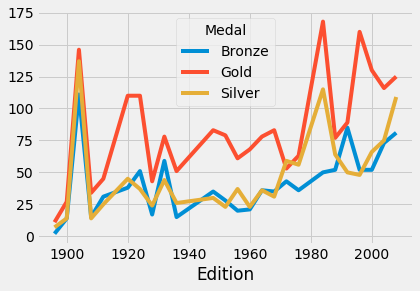

In [76]:
# Create the DataFrame: usa
usa = medals.loc[medals['NOC'] == 'USA']

# Group usa by ['Edition', 'Medal'] and aggregate over 'Athlete'
usa_medals_by_year = usa.groupby(['Edition','Medal'])['Athlete'].count()

display(usa_medals_by_year.head())

# Reshape usa_medals_by_year by unstacking
usa_medals_by_year = usa_medals_by_year.unstack(level='Medal')

display(usa_medals_by_year.head())

# Plot the DataFrame usa_medals_by_year
usa_medals_by_year.plot()
plt.show()

### Visualizing USA Medal Counts by Edition: Area Plot

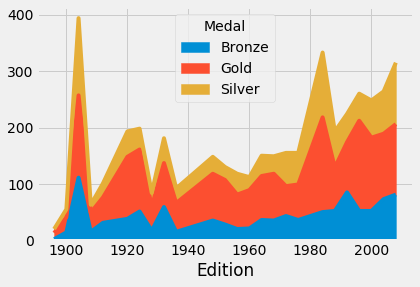

In [77]:
#Create the DataFrame: usa
usa = medals[medals.NOC == 'USA']

# Group usa by 'Edition', 'Medal', and 'Athlete'
usa_medals_by_year = usa.groupby(['Edition', 'Medal'])['Athlete'].count()

# Reshape usa_medals_by_year by unstacking
usa_medals_by_year = usa_medals_by_year.unstack(level='Medal')

# Create an area plot of usa_medals_by_year
usa_medals_by_year.plot.area()
plt.show()

### Visualizing USA Medal Counts by Edition: Area Plot with Ordered Medals
The medals are ordered according to a lexicographic (dictionary) ordering: Bronze < Gold < Silver. Prefer an ordering consistent with the Olympic rules: Bronze < Silver < Gold.

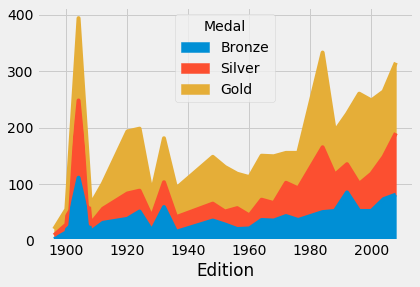

In [82]:
# Redefine 'Medal' as an ordered categorical
medals.Medal = pd.Categorical(values=medals.Medal,categories=['Bronze','Silver','Gold'],ordered=True)

# Create the DataFrame: usa
usa = medals[medals.NOC == 'USA']

# Group usa by 'Edition', 'Medal', and 'Athlete'
usa_medals_by_year = usa.groupby(['Edition', 'Medal'])['Athlete'].count()

# Reshape usa_medals_by_year by unstacking
usa_medals_by_year = usa_medals_by_year.unstack(level='Medal')

# Create an area plot of usa_medals_by_year
usa_medals_by_year.plot.area()
plt.show()